# Estimate GRF
---
This notebook estimates Noisy [1,2] parameters from Gaussian Random Fields movies. 

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [117]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy as sci
from ipywidgets import interact, fixed
import ipywidgets as widget
import pynoisy.eht_functions as ehtf
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [118]:
def compare_movie_frames(movie1, movie2):
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    plt.tight_layout()
    mean_images = [movie1.frames.mean(axis=0), 
                   movie2.frames.mean(axis=0), 
                   (np.abs(movie1.frames - movie2.frames)).mean(axis=0)]
    cbars = []
    for ax, image in zip(axes, mean_images):
        im = ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbars.append(fig.colorbar(im, cax=cax))
                     
    def imshow_frame(i, movie1, movie2, axes, cbars):
        image1 = movie1.frames[i]
        image2 = movie2.frames[i]
        image3 = np.abs(movie1.frames[i] - movie2.frames[i])
        
        for ax, img, title, cbar in zip(axes, [image1, image2, image3], 
                                        ['Movie1', 'Movie2', 'Absolute difference'], cbars):
            im = ax.imshow(img)
            ax.set_title(title)
            cbar.mappable.set_clim([img.min(), img.max()])
            
    interact(
        imshow_frame, i=(0, pynoisy.core.get_num_frames()-1), 
        movie1=fixed(movie1),movie2=fixed(movie2), axes=fixed(axes), cbars=fixed(cbars)
    );

## Forward Model

In [3]:
advection = pynoisy.DiskAdvection()
diffusion = pynoisy.RingDiffusion()

solver = pynoisy.PDESolver(advection, diffusion)
source = np.random.randn(solver.num_frames, *pynoisy.core.get_image_size()) * solver.forcing_strength
random_field = solver.run_adjoint(source=source, verbose=True)
random_field.save('./random_field_adjoint1')
np.save('./source_adjoint1', source)

<IPython.core.display.Javascript object>


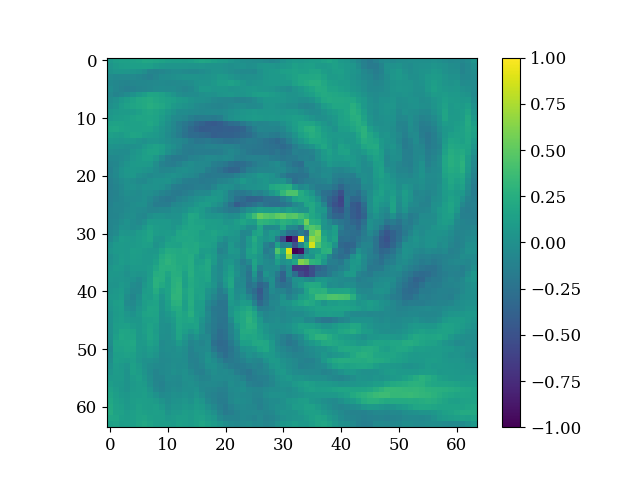

In [4]:
%matplotlib notebook
anim = random_field.get_animation(vmin=-1, vmax=1)

## Inverse Model

In [119]:
"""
Load true random field
"""
random_field_true = pynoisy.Movie()
random_field_true.load('./random_field_adjoint1')
source = np.load('./source_adjoint1.npy')


# True Advection / Diffusion
advection_true = pynoisy.DiskAdvection()
diffusion_true = pynoisy.RingDiffusion()

<IPython.core.display.Javascript object>


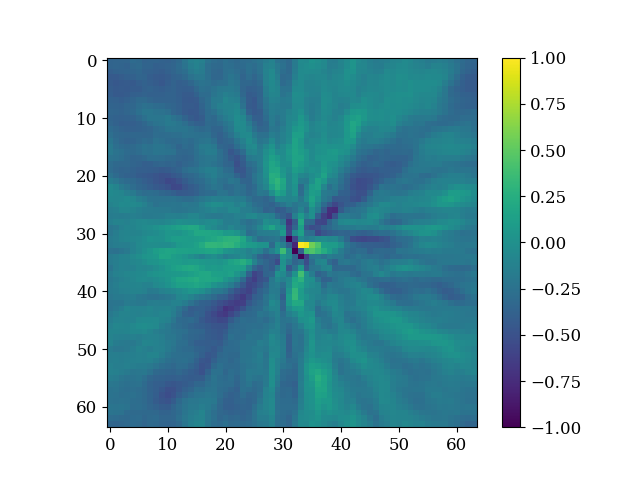

In [4]:
"""
Init diffusion
"""
diffusion = pynoisy.RingDiffusion(opening_angle=0.0)
solver = pynoisy.PDESolver(advection_true, diffusion)
adjoint_solver = pynoisy.PDESolver(advection=-advection_true, diffusion=diffusion)
random_field = solver.run_adjoint(source=source)

%matplotlib notebook
anim = random_field.get_animation(vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


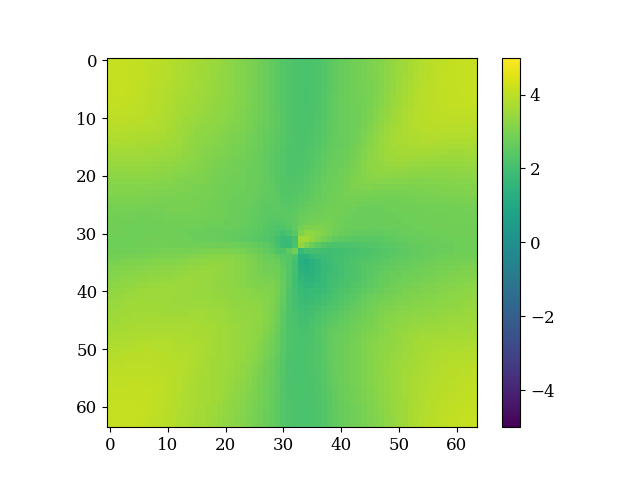

In [5]:
error = pynoisy.Movie(random_field_true.frames - random_field.frames)
backprop = adjoint_solver.run_adjoint(source=error.reverse_time().frames)

anim = backprop.get_animation(vmin=-5, vmax=5)

In [136]:
diffusion_true.opening_angle

1.0471975511965976

In [134]:
from scipy.optimize import minimize

class Optimizer(object):
    def __init__(self):
        self._nfeval = 0
        print('{0:4s}   {1:9s} '.format('Iter', ' angle'))
        
    def objective_fun(self, x):
        diffusion = pynoisy.RingDiffusion(opening_angle=x)
        forward_solver = pynoisy.PDESolver(advection=advection_true, diffusion=diffusion)
        adjoint_solver = pynoisy.PDESolver(advection=-advection_true, diffusion=diffusion)
        random_field = forward_solver.run_adjoint(source=source, verbose=False)
        error = random_field.frames - random_field_true.frames
        loss = np.abs(error).mean()
        backprop = adjoint_solver.run_adjoint(source=pynoisy.Movie(error).reverse_time().frames, verbose=False)

        dx = 1e-2
        diffusion_f = pynoisy.RingDiffusion(opening_angle=x+dx)
        jac_angle = (diffusion_f.get_laplacian(random_field.frames) - 
                     diffusion.get_laplacian(random_field.frames)) / dx
        gradient = np.mean(backprop.frames * jac_angle)
        return np.array(loss), np.array(gradient)

    def callback_fun(self, x):
        print('{}    {}'.format(self._nfeval, x))
        self._nfeval += 1
        
    def minimize(self, x0):
        result = minimize(fun=self.objective_fun, x0=np.array(x0), method='L-BFGS-B', jac=True, callback=self.callback_fun)
        return result

In [135]:
optimizer = Optimizer()
result = optimizer.minimize(x0=0)
result

Iter    angle    
0    [1.]
1    [1.02708401]
2    [1.0290332]
3    [1.03823148]
4    [1.04160072]
5    [1.04160072]


      fun: array(0.00095395)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array(4.38259872)
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 6
   status: 0
  success: True
        x: array([1.04160072])

In [137]:
optimizer = Optimizer()
result = optimizer.minimize(x0=3.05)
result

Iter    angle    
0    [2.05]
1    [2.0336636]
2    [2.0336636]


      fun: array(0.11460092)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array(24.89156451)
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 44
      nit: 3
   status: 0
  success: True
        x: array([2.0336636])

In [138]:
2.0336636 - np.pi

-1.107929053589793